# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

ModuleNotFoundError: No module named 'pandas'

In [2]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2026/data_forecast_2026_silver/ingresos_membresia_anual_ecobici_plus_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2024-05-03 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,16,13574.9,2024-05-03,13574.9
1,12,10788.0,2024-05-04,10788.0
2,19,17081.0,2024-05-05,17081.0
3,12,10788.0,2024-05-06,10788.0
4,9,8091.0,2024-05-07,8091.0


Filtro para obtener muestra de datos

In [3]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [4]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.05,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


14:47:56 - cmdstanpy - INFO - Chain [1] start processing
14:47:56 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [5]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

            ds
934 2026-11-26
935 2026-11-27
936 2026-11-28
937 2026-11-29
938 2026-11-30


Paso 5: Realizar la Predicción (Forecast)

In [6]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds        yhat   yhat_lower   yhat_upper
934 2026-11-26  635.453719 -3373.344127  4396.515425
935 2026-11-27  633.818556 -3533.035118  4348.048200
936 2026-11-28  726.812512 -3178.682491  4707.661054
937 2026-11-29  844.625408 -2877.030374  4562.504498
938 2026-11-30  564.118167 -3296.997247  4418.068748


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

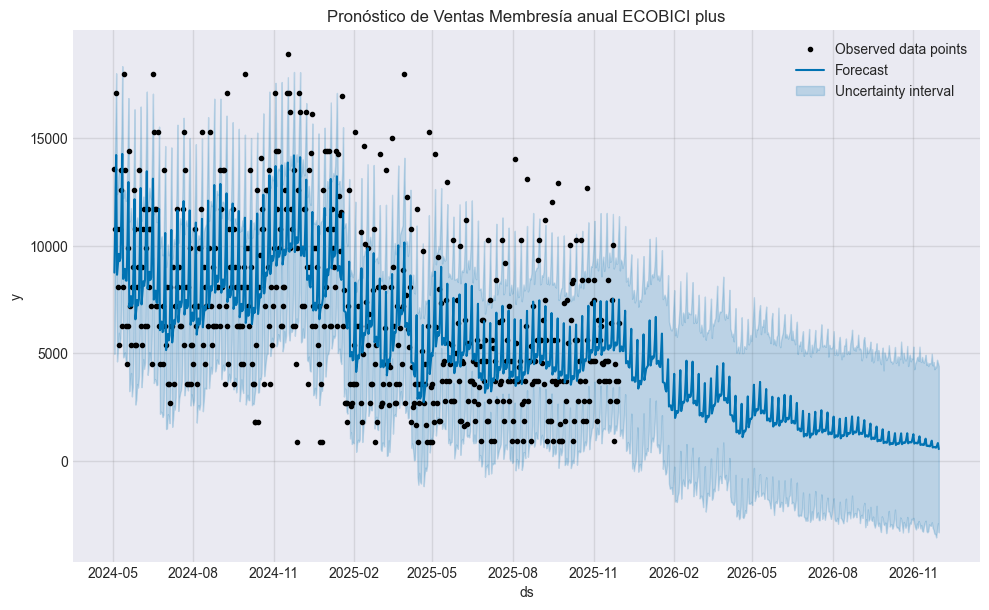

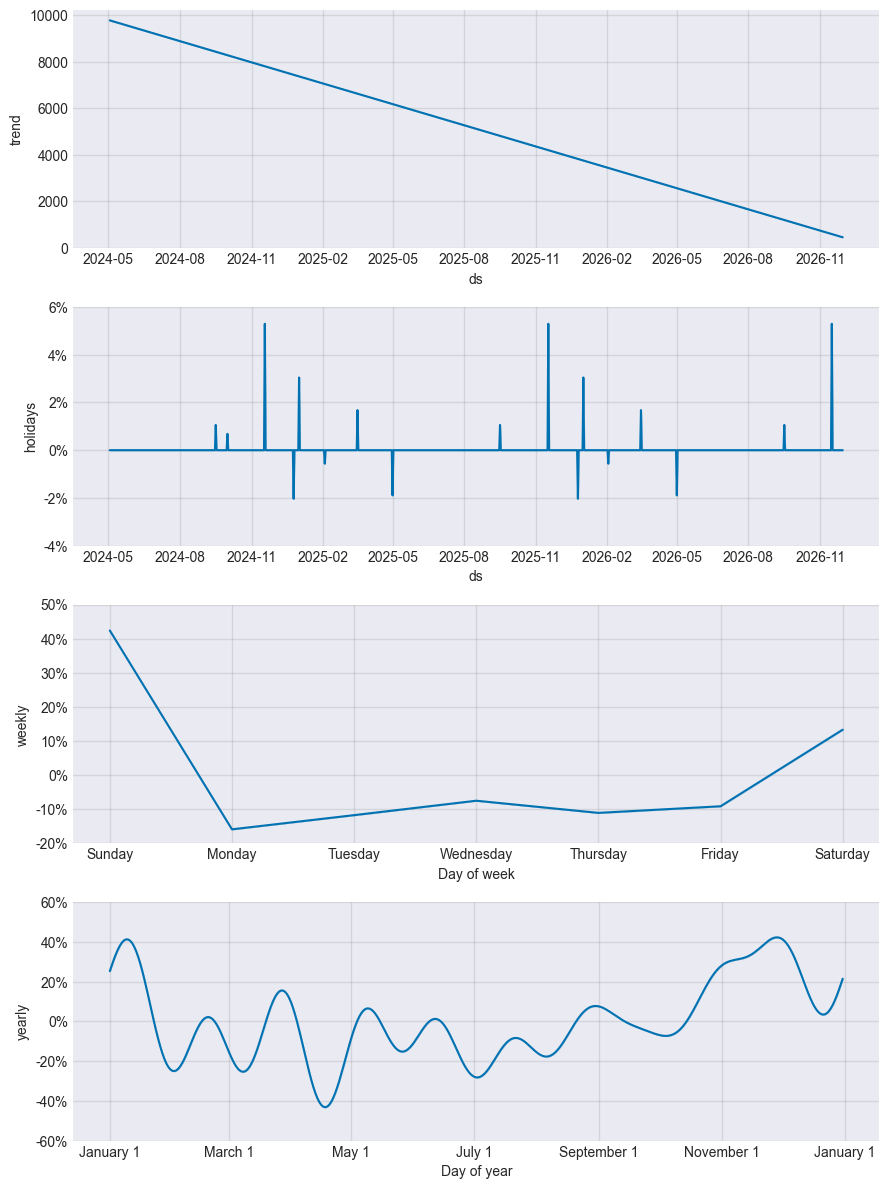

In [7]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas Membresía anual ECOBICI plus")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [8]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month       yhat  yhat_lower  yhat_upper
0   2024-05  266247.50   155842.78   378621.00
1   2024-06  260436.57   144705.58   375635.88
2   2024-07  231428.29   111919.69   350230.99
3   2024-08  253881.18   134757.46   373841.37
4   2024-09  254741.15   139623.42   368880.44
5   2024-10  264592.49   144819.81   383509.97
6   2024-11  318163.09   201785.81   433710.58
7   2024-12  277015.06   157713.72   398376.60
8   2025-01  261263.35   141396.17   381259.96
9   2025-02  175981.72    68662.49   282874.78
10  2025-03  194321.38    74569.05   314324.39
11  2025-04  142693.64    26709.69   257962.71
12  2025-05  173676.63    57424.87   289365.69
13  2025-06  158213.78    41546.62   274334.36
14  2025-07  134782.15    20383.93   250922.43
15  2025-08  151012.82    31212.90   272630.61
16  2025-09  142993.12    29097.47   259338.51
17  2025-10  141501.26    27204.72   258091.09
18  2025-11  173033.11    57186.13   290465.21
19  2025-12  142129.45    22212.25   261143.68
20  2026-01  

In [9]:
monthly_sales.to_csv("../data/data_forecast_2026/data_forecast_2026_gold/forecast_anual_ecobici_plus.csv")

In [ ]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())s

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.